# Homework 3

## Question 1: Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

In [168]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.pyplot import cm
from operator import itemgetter
%matplotlib inline 

In [169]:
df = pd.read_csv('lalonde.csv').set_index('id')
df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


There are some zero valued columns in re78 which we need to either interpolate or drop.

In [170]:
def interpolate(df):
    """interpolate missing values"""
    s = df['re78'].values # salary column
    s[s==0] = np.nan
    df['re78'] = s
    df = df.interpolate() # Pandas interpolation
    return df

def delete_zeros(df):
    """delete missing values"""
    def count_treatment(df):
        """print how many people are treated and how many are not, before and after zeros interpolation"""
        counts_treated = df.groupby('treat').count().values[:,-1]
        zeros_treated = df[df['re78']==0].groupby('treat').count().values
        if len(zeros_treated) == 0:
            zeros_treated =[0, 0]
        else:
            zeros_treated = zeros_treated[:,-1]
        print("treated: "+str(counts_treated[0]))
        print("treated zeros: "+str(zeros_treated[0]))
        print("not treated: "+str(counts_treated[1]))
        print("not treated zeros: "+str(zeros_treated[1]))
    count_treatment(df)
    df = df[df['re78']!=0]
    count_treatment(df)

In [171]:
df = interpolate(df)

#### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?


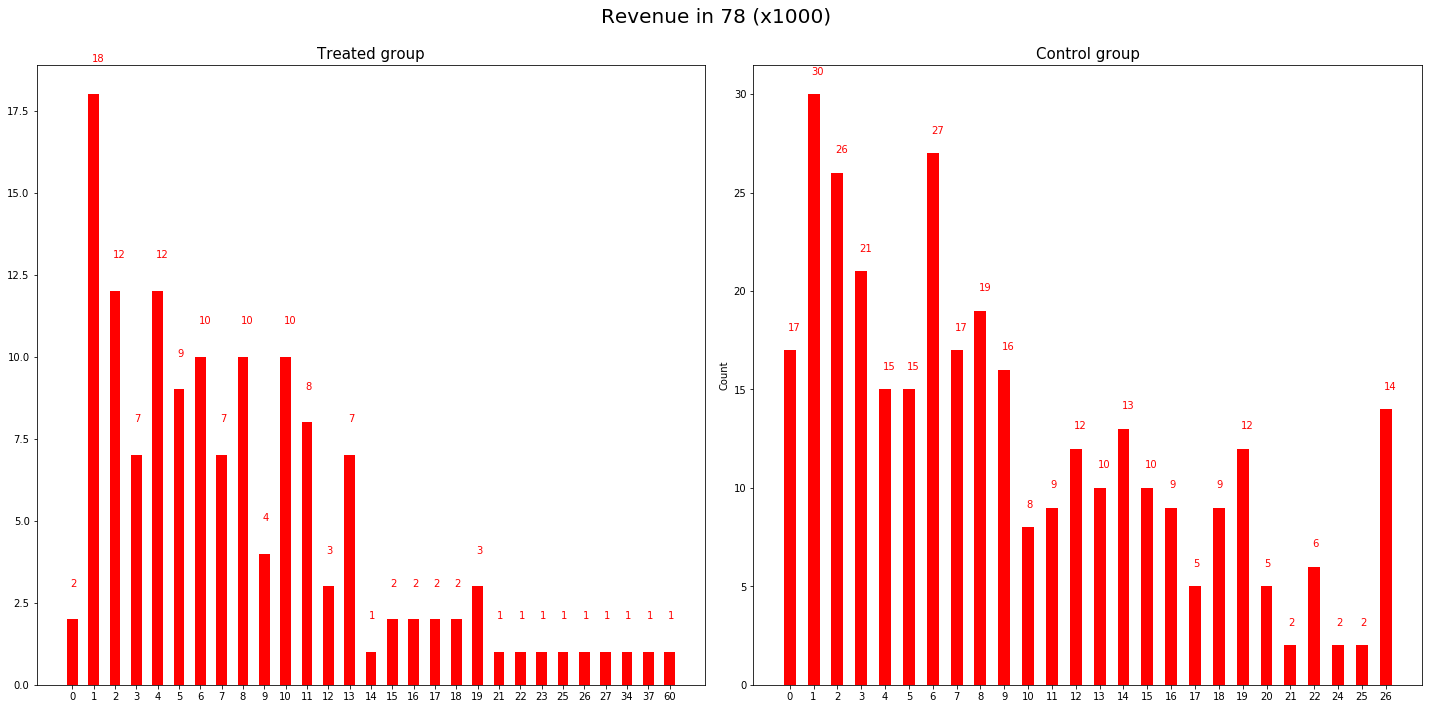

In [172]:
def plot_histogram_old(x0, y0, x1, y1, title, figsize=(20,10)):
    """
    This functions plots a histogram adding the values on top of the bins.

    x: values of the attribute that is being counted
    y: counts of the x values
    title: title to give to the histogram
    abscissa: absissa to be displayed (what is being counted)
    """
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
    width = 0.5 # the width of the bars
    ind0 = np.arange(len(y0))
    ind1 = np.arange(len(y1))
    
    ax[0].bar(ind0, y0, width, color="red")
    ax[0].set_xticks(ind0)
    ax[0].set_xticklabels(x0, minor=False)
    
    ax[1].bar(ind1, y1, width, color="red")
    ax[1].set_xticks(ind1)
    ax[1].set_xticklabels(x1, minor=False)
    
    plt.ylabel('Count')

    for i, v in enumerate(y0):
        ax[0].text(i-width/6, v+ 1, str(v), color='red')
    for i, v in enumerate(y1):
        ax[1].text(i-width/6, v+ 1, str(v), color='red')
        
    ax[0].set_title('Treated group', fontsize=15)
    ax[1].set_title('Control group', fontsize=15)
    fig.suptitle(title, fontsize=20)
    plt.tight_layout()
    fig.subplots_adjust(top=0.9)
    plt.show()
    
plot_histogram_old(x_treated, y_treated, x_control, y_control, title='Revenue in 78 (x1000)')
    

In [173]:
df.groupby('treat').mean().round(2)

,age,educ,black,hispan,married,nodegree,re74,re75,re78
treat,,,,,,,,,
0,28.03,10.24,0.20,0.14,0.51,0.60,5619.24,2466.48,8703.27
1,25.82,10.35,0.84,0.06,0.19,0.71,2095.57,1532.06,8256.96


In [63]:
print('Treated group : {} individuals and mean earnings in 1978 : {}'.format(len(df.loc[df.treat == 1]), int(df.loc[df.treat == 1, 're78'].mean())))
print('Control group : {} individuals and mean earnings in 1978 : {}'.format(len(df.loc[df.treat == 0]), int(df.loc[df.treat == 0, 're78'].mean())))

Treated group : 140 individuals and mean earnings in 1978 : 8389
Control group : 331 individuals and mean earnings in 1978 : 9051


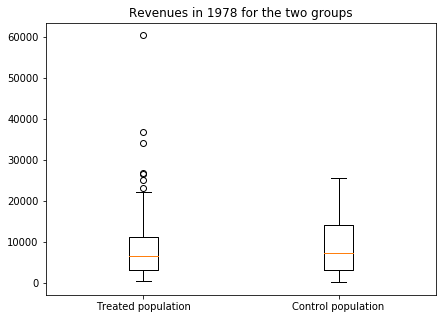

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
ax.boxplot([df.loc[df.treat == 1, 're78'].values, df.loc[df.treat == 0, 're78'].values])
ax.set_title('Revenues in 1978 for the two groups')
ax.set_xticklabels(['Treated population', 'Control population'])
plt.show()

Let's plot the histograms of the distribution of revenues rounded to the closest thousand.

In [65]:
treated_x = df.loc[df.treat == 1, 're78'].values.round(-3)
control_x = df.loc[df.treat == 0, 're78'].values.round(-3)

x_treated, y_treated = np.unique(treated_x, return_counts=True)
x_treated = (x_treated/1000).astype(int)

x_control, y_control = np.unique(control_x, return_counts=True)
x_control = (x_control/1000).astype(int)

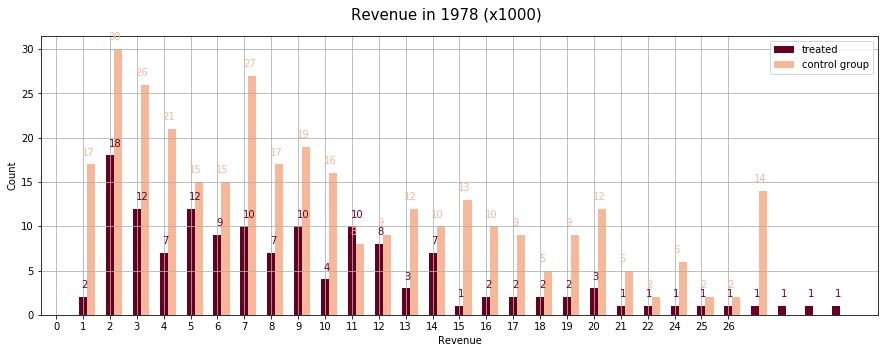

In [66]:
def plot_histogram(xs, ys, title, figsize=(20,10)):
    """
    This functions plots a histogram adding the values on top of the bins.

    x: values of the attribute that is being counted
    y: counts of the x values
    title: title to give to the histogram
    abscissa: absissa to be displayed (what is being counted)
    """
    
    color = cm.RdGy(np.linspace(0, 1, 4))
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    width = figsize[0]/50 # the width of the bars
    offset = figsize[0]/50 # distance between two bars

    i = 0
    for (x,y) in zip(xs,ys):
        ind = np.arange(len(y))
        ax.bar(ind + offset*i, y, width, color=color[i])
        ax.set_xticks(ind - 1)
        ax.set_xticklabels(x, minor=False)

        
        for j, v in enumerate(y):
            ax.text(j-width/6, v + 1, str(v), color=color[i])
        i = i + 1
        
    fig.suptitle(title, fontsize=15)
    plt.grid()
    plt.xlabel('Revenue')
    plt.ylabel('Count')
    plt.legend(["treated","control group"])
    fig.subplots_adjust(top=0.9)
    plt.show()
    
plot_histogram([x_treated,x_control], [y_treated, y_control], title='Revenue in 1978 (x1000)', figsize=(15,5))

The two previous histograms are difficult to interpret and don't seem to give a lot of insight on the data.

The two boxplots however tell us that, excepting the outliers, it seems that the distribution of outcomes for the treated population is still under the one of the control population. A 'naive' researcher might conclude that the effect of the training program seems limited.

#### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

In [52]:
print('Treated group average earnings in 1974 : {}'.format(int(df.loc[df.treat == 1, 're74'].mean())))
print('Control group average earnings in 1974 : {}'.format(int(df.loc[df.treat == 0, 're74'].mean())))
print('')
print('Treated group average earnings in 1975 : {}'.format(int(df.loc[df.treat == 1, 're75'].mean())))
print('Control group average earnings in 1975 : {}'.format(int(df.loc[df.treat == 0, 're75'].mean())))
print('')
print('Treated group average earnings in 1978 : {}'.format(int(df.loc[df.treat == 1, 're78'].mean())))
print('Control group average earnings in 1978 : {}'.format(int(df.loc[df.treat == 0, 're78'].mean())))

Treated group average earnings in 1974 : 2095
Control group average earnings in 1974 : 5619

Treated group average earnings in 1975 : 1532
Control group average earnings in 1975 : 2466

Treated group average earnings in 1978 : 6349
Control group average earnings in 1978 : 6984


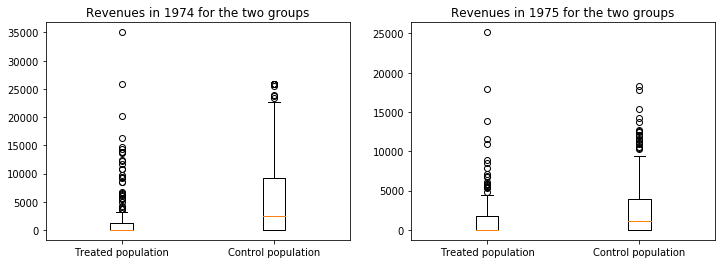

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax[0].boxplot([df.loc[df.treat == 1, 're74'].values, df.loc[df.treat == 0, 're74'].values])
ax[0].set_title('Revenues in 1974 for the two groups')
ax[0].set_xticklabels(['Treated population', 'Control population'])

ax[1].boxplot([df.loc[df.treat == 1, 're75'].values, df.loc[df.treat == 0, 're75'].values])
ax[1].set_title('Revenues in 1975 for the two groups')
ax[1].set_xticklabels(['Treated population', 'Control population'])
plt.show()

#### 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

In [109]:
from sklearn import linear_model
from sklearn import metrics
logistic = linear_model.LogisticRegression()

In [110]:
# training data
X = np.asarray(df.drop(['treat','re78'], axis=1).values)
Y = np.asarray(df['treat'].values)
print("Shape of X: " + str(np.shape(X)))
print("Shape of Y: " + str(np.shape(Y)))

Shape of X: (614, 8)
Shape of Y: (614,)


In [111]:
logistic.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [112]:
pred = logistic.predict(X) 

Next, we want to print some accuracy measures (remember, we only train and evaluate the model on the traning). We chose to show the following measures, based on the confusino matrix:

| Confusion matrix |          |              |       |
|:----------------:|:--------:|:------------:|:-----:|
|                  | Relevant | Non-relevant | Total |
|     Retrieved    |    TP    |      FP      |   Pp  |
|   Not retrieved  |    FN    |      TN      |   Np  |
|       Total      |     P    |       N      |   n   |

**Producer accuracy (Recall)** measures how large a fraction of the expected results is actually found_
$R=\frac{TP}{TP+FN}$

**User accuracy (Precision)** measures how many of the results returned are actually relevant.
$P=\frac{TP}{TP+FP}$

**F-Score** as a a weighted harmonic measure between the precision and recall:
$F1=\frac{2PR}{P+R}$

**Overall Accuracy** measures how many of the labels have been correctly classified.
$OA=\frac{\sum_in_{ii}}{n}$

**Intersection over Union** (a.k.a. Jaccard Score), which is very widely spread in binary classification:
$IoU_{i}=\frac{n_{ii}}{n_{i.}+n_{.i}-n_{ii}}=\frac{\text{TP}}{\text{Pp}+\text{P}-\text{TP}}$


|  |  | True labels y |  |  |  | PA |
|:------------------:|:--------:|:----------------------:|:----------------------:|:--------:|:----------------------:|:------------------------------------:|
| Predicted labels y |  | 1 | 2 | $\dots$ | r |  |
|  | 1 | $n_{11}$ | $n_{12}$ | $\dots$ | $n_{1r}$ | $n_{11}/n_{1\bullet}$ |
|  | 2 | $n_{21}$ | $n_{22}$ | $\dots$ | $n_{2r}$ | $n_{22}/n_{2\bullet}$ |
|  | $\vdots$ | $\vdots$ | $\vdots$ | $\ddots$ | $\vdots$ | $\vdots$ |
|  | r | $n_{r1}$ | $n_{r2}$ | $\dots$ | $n_{rr}$ | $n_{rr}/n_{r\bullet}$ |
| UA |  | $n_{11}/n_{\bullet 1}$ | $n_{22}/n_{\bullet 2}$ | $\dots$ | $n_{rr}/n_{\bullet r}$ | OA$=\sum_in_{ii}/n_{\bullet\bullet}$ |

In [115]:
def print_metrics(pred,Y):
    """print some accuracy measures after training"""
    # get predictions of logistic regression
    
    # get overall accuracy
    pred_prob = logistic.predict_proba(X)
    print("Overall accuracy: " + str(np.round(metrics.accuracy_score(Y,pred),2)))
    print("Recall: " + str(np.round(metrics.recall_score(Y,pred),2)))
    print("Precision: " + str(np.round(metrics.precision_score(Y,pred),2)))
    print("F-Score: " + str(np.round(metrics.f1_score(Y,pred),2)))

print_metrics(pred,Y)

Overall accuracy: 0.81
Recall: 0.72
Precision: 0.67
F-Score: 0.69


#### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

#### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.

#### 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

## Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

1. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

2. Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [12]:
def plot_confusion_matrix(mat):
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(mat, cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax)
    plt.show()

#### Import the data

In [13]:
newsgroups_train = fetch_20newsgroups(subset='train')

#### Compute the df-idf matrix

In [14]:
# declare the vectorizer
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)
# compute the td-idf features
tfidf = vectorizer.fit_transform(newsgroups_train['data'])
# get the correspondance between features and words
feature_names = vectorizer.get_feature_names()

#### Split data set in train, test and validation tests (80%, 10%, 10%) 

In [15]:
# split in train (80%) and tmp (20%)
X_train, X_tmp, y_train, y_tmp = train_test_split(tfidf, newsgroups_train['target'], test_size=0.2, random_state=42)
# split tmp in test and validation (50% - 50%) ~ (10% - 10%)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

In [16]:
X_train.shape, X_test.shape, X_val.shape

((9051, 129796), (1132, 129796), (1131, 129796))

#### Train the random forest

First we use the default parameters.

In [17]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Predict on test and visualize confusion matrix

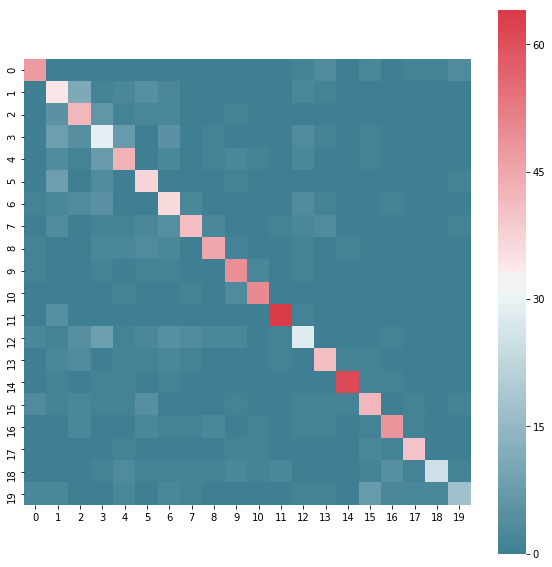

In [18]:
y_predict = clf.predict(X_test)
plot_confusion_matrix(np.asarray(confusion_matrix(y_test, y_predict)))

#### Grid search to find the best parameters

In [19]:
parameters = {'n_estimators':[10, 30, 50, 100, 200], 'max_depth':[10, 20, 50, 100, 200]}
grid_search = GridSearchCV(clf, parameters)

In [20]:
grid_search.fit(X_val, y_val)
grid_search.best_params_

{'max_depth': 100, 'n_estimators': 200}

#### Train and test of the classifier with these parameters

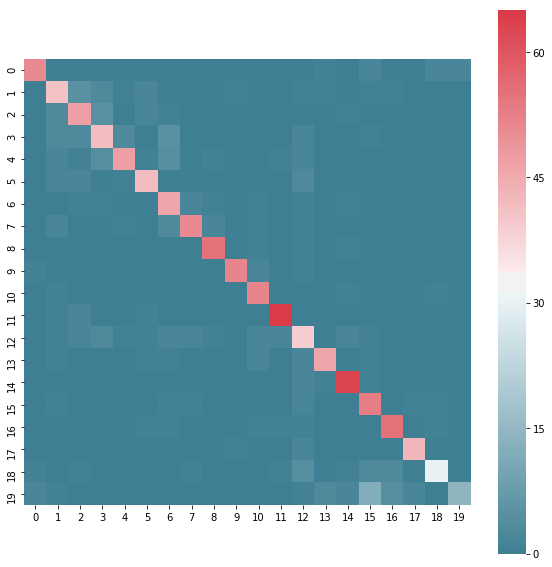

In [24]:
clf = RandomForestClassifier(n_estimators=200, max_depth=50)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

plot_confusion_matrix(np.asarray(confusion_matrix(y_test, y_predict)))

This matrix shows that the prediction is far more accurate using the tuned hyperparameters found by grid search.
Blue is darker outside of the diagonal (less errors of classification).

#### Feature importance

Now let's look at the `feature_importances_` of the classifier and see the correspondance with terms in the text.

We'll look at the 20 more important features and the corresponding terms.

In [22]:
ind = list(np.argsort(clf.feature_importances_)[-20:])

In [23]:
itemgetter(*ind)(feature_names)

('crypto',
 'orbit',
 'chip',
 'gun',
 'team',
 'jesus',
 'israeli',
 'nhl',
 'hockey',
 'key',
 'israel',
 'god',
 'space',
 'encryption',
 'car',
 'bike',
 'clipper',
 'windows',
 'dod',
 'sale')

TODO:
- discuss the results
- improve classifications by doing data cleaning (tokenization ?)
- compute score of classification